#Separation of CIFAR-10 Images

The model takes as input an image created by averaging two random samples from CIFAR-10 and is tasked with predicting the categories of the two components.

The first image belongs to the first five categories (airplane, automobile, bird, cat, deer), while the second belongs to the remaining categories (dog, frog, horse, ship, truck). The model must return two labels, each within a range of five possible values.

The evaluation metric for the model is as follows: calculate the classification accuracy for the two component images and then compute their average.

The metric should be evaluated on 10,000 inputs generated from test data. Repeat the calculation 10 times and measure the standard deviation, which must be reported.

A data generator and some examples are provided below.

#Data preparation

In [20]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
from matplotlib import pyplot as plt

In [21]:
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()
assert cifar10_x_train.shape == (50000, 32, 32, 3)
assert cifar10_x_test.shape == (10000, 32, 32, 3)
assert cifar10_y_train.shape == (50000, 1)
assert cifar10_y_test.shape == (10000, 1)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

cifar10_x_train = (cifar10_x_train/255.).astype(np.float32)
cifar10_x_test = (cifar10_x_test/255.).astype(np.float32)

Let us split the images in two groups, according to their label.

In [22]:
cond_1 = cifar10_y_train[:,0] < 5
cifar10_x_train_1 = cifar10_x_train[cond_1]
cifar10_y_train_1 = cifar10_y_train[cond_1]

cond_2 = cifar10_y_train[:,0] >= 5
cifar10_x_train_2 = cifar10_x_train[cond_2]
cifar10_y_train_2 = cifar10_y_train[cond_2]

cond_1_test = cifar10_y_test[:,0] < 5
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:,0] >= 5
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]

Now we can define the generator. The input consists of two datasets (X1,X2), their corresponding labels (Y1,Y2), and a batch size.

The generator returns (x_data,y_data), where:
* x_data is a batch of images obtained by averaging random samples from X1 and X2.
* y_data is a pair of batches of labels corresponding to the component images, expressed in categorical format.

In [23]:
def datagenerator(X1, X2, Y1, Y2, batchsize):
    size1 = X1.shape[0]
    size2 = X2.shape[0]
    Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=5)
    Y2_cat = tf.keras.utils.to_categorical(Y2 - 5, num_classes=5)

    while True:
        num1 = np.random.randint(0, size1, batchsize)
        num2 = np.random.randint(0, size2, batchsize)
        x_data = (X1[num1] + X2[num2]) / 2.0
        y_data = (Y1_cat[num1], Y2_cat[num2])
        yield x_data, y_data


Let us instantiate a generator on Cifar10 with batchsize=1, and let's see its behaviour.

In [24]:
datagen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,1)

Let's generate an example, display the image that the model will take as input, and print the categories of the two overlapping components.

You can re-run the cell to display new examples.

first: airplane, second = truck


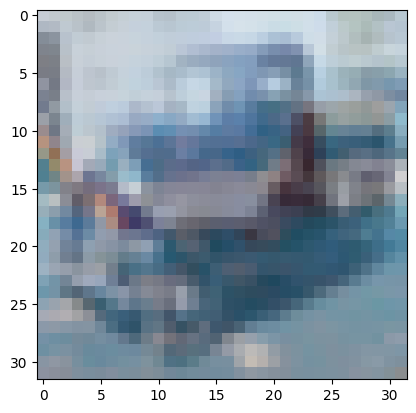

In [25]:
x, y = next(datagen)

print("first: {}, second = {}".format(classes[np.argmax(y[0][0])],classes[np.argmax(y[1][0])+5]))
#print(np.min(x[0]),np.max(x[0]))
plt.imshow(x[0])

# Model Evaluation

Let us define first of all the test generator.

In [26]:
testgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,10000)

eval_samples_x, eval_samples_y = next(testgen)
print(eval_samples_x.shape)

(10000, 32, 32, 3)


We now test a model producing random guesses. You will need to replace it with your own predictive model.

In [27]:
def random_model(x):
  #the random model ingnore the input x and return a pair of random classes
  return(np.random.randint(0,5,(10000,2)))

In [28]:
def eval_model(model):
  eval_samples_x, eval_samples_y = next(testgen)
  random_guesses = model(eval_samples_x)
  correct_guesses_1 = random_guesses[:,0] == np.argmax(eval_samples_y[0],axis=1)
  correct_guesses_2 = random_guesses[:,1] == np.argmax(eval_samples_y[1],axis=1)
  return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2))/2

In [29]:
eval_model(random_model)

0.19915

As expected, the accuracy is around 1/5 = 0.2

Let us repeat the evaluation ten times, and compute the standard deviation

In [30]:
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(random_model))
print("mean accuracy = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

mean accuracy =  0.20027499999999998
standard deviation =  0.0017261590309122752


### Experiment 2: Unet

In [31]:
"""
# Define U-Net Model
def unet_model():
    inputs = tf.keras.Input(shape=(32, 32, 3))

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u1 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u1 = layers.concatenate([u1, c3])
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u2 = layers.concatenate([u2, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u3 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u3 = layers.concatenate([u3, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    # Output layers for each label
    c7_flattened = layers.Flatten()(c7)
    output1 = layers.Dense(5, activation='softmax', name='output1')(c7_flattened)
    output2 = layers.Dense(5, activation='softmax', name='output2')(c7_flattened)

    model = Model(inputs=inputs, outputs=[output1, output2])
    return model
"""

"\n# Define U-Net Model\ndef unet_model():\n    inputs = tf.keras.Input(shape=(32, 32, 3))\n\n    # Encoder\n    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)\n    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)\n    p1 = layers.MaxPooling2D((2, 2))(c1)\n\n    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)\n    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)\n    p2 = layers.MaxPooling2D((2, 2))(c2)\n\n    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)\n    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)\n    p3 = layers.MaxPooling2D((2, 2))(c3)\n\n    # Bottleneck\n    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)\n    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)\n\n    # Decoder\n    u1 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)\n    u1 = layers.concatenate([u1,

In [32]:
def build_deep_unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    p5 = layers.MaxPooling2D((2, 2))(c5)

    # Bottleneck
    bn = layers.Conv2D(2048, (3, 3), activation='relu', padding='same')(p5)
    bn = layers.Conv2D(2048, (3, 3), activation='relu', padding='same')(bn)

    # Decoder
    u5 = layers.Conv2DTranspose(1024, (3, 3), strides=(2, 2), padding='same')(bn)
    u5 = layers.concatenate([u5, c5])
    u5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(u5)
    u5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(u5)

    u4 = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(u5)
    u4 = layers.concatenate([u4, c4])
    u4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u4)
    u4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u4)

    u3 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(u4)
    u3 = layers.concatenate([u3, c3])
    u3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u3)
    u3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u3)

    u2 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(u3)
    u2 = layers.concatenate([u2, c2])
    u2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)

    u1 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(u2)
    u1 = layers.concatenate([u1, c1])
    u1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)

    # Output layers for each label
    u1_flattened = layers.Flatten()(u1)
    output1 = layers.Dense(5, activation='softmax', name='output1')(u1_flattened)
    output2 = layers.Dense(5, activation='softmax', name='output2')(u1_flattened)

    model = Model(inputs=inputs, outputs=[output1, output2])
    return model

In [33]:
"""model = unet_model()"""
model = build_deep_unet((32, 32, 3))
model.compile(optimizer='adam',
              loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})


In [34]:
train_gen = datagenerator(cifar10_x_train_1, cifar10_x_train_2, cifar10_y_train_1, cifar10_y_train_2, 64)
val_gen = datagenerator(cifar10_x_test_1, cifar10_x_test_2, cifar10_y_test_1, cifar10_y_test_2, 64)

history = model.fit(train_gen, steps_per_epoch=500, epochs=10, validation_data=val_gen, validation_steps=100)

#model.fit(train_gen, steps_per_epoch=500, epochs=10)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1742s 3s/step - loss: 2.9439 - output1_accuracy: 0.3346 - output1_loss: 1.4933 - output2_accuracy: 0.3604 - output2_loss: 1.4506
Epoch 2/10
319/500 ━━━━━━━━━━━━━━━━━━━━ 10:31 3s/step - loss: 2.5133 - output1_accuracy: 0.4518 - output1_loss: 1.3047 - output2_accuracy: 0.5135 - output2_loss: 1.2086

AbortedError: Graph execution error:

Detected at node StatefulPartitionedCall/gradient_tape/functional_2_1/conv2d_28_1/convolution/Conv2DBackpropFilter defined at (most recent call last):
<stack traces unavailable>
Operation received an exception:Status: 1, message: could not create a primitive, in file tensorflow/core/kernels/mkl/mkl_conv_grad_filter_ops.cc:685
	 [[{{node StatefulPartitionedCall/gradient_tape/functional_2_1/conv2d_28_1/convolution/Conv2DBackpropFilter}}]] [Op:__inference_multi_step_on_iterator_246533]

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
def eval_model(model):
    testgen = datagenerator(cifar10_x_test_1, cifar10_x_test_2, cifar10_y_test_1, cifar10_y_test_2, 10000)
    eval_samples_x, eval_samples_y = next(testgen)
    predictions = model.predict(eval_samples_x)
    pred1 = np.argmax(predictions[0], axis=1)
    pred2 = np.argmax(predictions[1], axis=1)
    correct_guesses_1 = pred1 == np.argmax(eval_samples_y[0], axis=1)
    correct_guesses_2 = pred2 == np.argmax(eval_samples_y[1], axis=1)
    return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2)) / 2

In [16]:
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
    eval_results.append(eval_model(model))

print("Mean accuracy =", np.mean(eval_results))
print("Standard deviation =", np.std(eval_results))


313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step
Mean accuracy = 0.58802
Standard deviation = 0.0028151554131166327


# What to Submit

As usual, you need to submit a single notebook that must be executable on Colab. The notebook should be properly commented and include a complete record of the training process, as well as the calculation of accuracy according to the guidelines provided above.

# Good luck!

